# Gradient Boosting Trees

#### Importación de librerías ⬇️

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import export_text, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OrdinalEncoder
from imblearn.combine import SMOTEENN

random_state = 42
test_size = 0.2

### Carga y Preparación de Datos

In [2]:
# Importar data de un csv
df = pd.read_csv('../data/los_data_gt_01.csv')

In [3]:
column_dtypes = df.dtypes

# Iterate through each column dtype and change dtype to "category" if it's "object"
for col_name, dtype in column_dtypes.items():
    if dtype == 'object':
        df[col_name] = df[col_name].astype('category')

# Define conditions for categorizing dias_estancia
conditions = [
    (df['dias_estancia'] < 5),
    (df['dias_estancia'] >= 5)
]

# Define labels for the categories
labels = [0, 1]

# Create a new column 'categoria_estancia' based on the conditions and labels
df['categoria_estancia'] = np.select(conditions, labels)

Como regla general, los algoritmos de ML basados en árboles no requieren de normalización/scaling de datos numéricos, pero sí requieren de codificación de las variables categoricas. La decisión de qué tipo de codificación usar se basó en la documentación de Gradient Boosting Trees de scikit-learn, donde se obtuvo que la codificación ordinal nativa de HistGradientBoosting es superior en cuanto a error medio y tiempo de entrenamiento en comparación con otros tipos de codificación como One Hot (https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html). A pesar de esto, la implementación nativa de esta codificación posee la limitante de solamente tratar con 255 categorías o menos, por lo que será necesario codificar algunas variables previo al entrenamiento del modelo.

In [4]:
# Initialize the encoder
encoder = OrdinalEncoder()

# Reshape the input data to a 2-dimensional array
data = df[['causa_atencion', 'municipio']]  # Selecting the columns you want to encode
data = data.values  # No need to reshape as we have multiple columns

# Fit and transform the encoder on the reshaped data
encoded_data = encoder.fit_transform(data)

# Assign the encoded data back to the DataFrame
df[['causa_atencion', 'municipio']] = encoded_data

### Funciones de Utilidad

In [14]:
def clfMetrics(clf, X, y):

    y_pred = clf.predict(X)

    # Accuracy
    accuracy = accuracy_score(y, y_pred)

    # Precision
    precision = precision_score(y, y_pred, average='micro')

    # Recall
    recall = recall_score(y, y_pred, average='micro')

    # F1 Score
    f1 = f1_score(y, y_pred, average='micro')

    # Confusion Matrix
    confusionMatrix = confusion_matrix(y, y_pred)

    # Initializing ConfusionMatrixDisplay with the confusion matrix
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

    fig, ax = plt.subplots(figsize=(10,10))

    # Plotting the confusion matrix
    cmDisplay.plot(ax=ax)
    plt.title('Matriz de Confusión de Modelo Clasificador')
    plt.show()

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [6]:
def CreateAndTestClassifier(X_train, X_test, y_train, y_test):
    clf = HistGradientBoostingClassifier(categorical_features="from_dtype", random_state=random_state)
    clf.fit(X_train, y_train)

    print("Performance Metrics on Test Set:")
    clfMetrics(clf, X_test, y_test)

    print("\nPerformance Metrics on Train Set:")
    clfMetrics(clf, X_train, y_train)

    return clf

In [17]:
def TuneAndTestClassifier(X_train, X_test, y_train, y_test):
    param_grid = {
        'max_depth': range(5, 16, 5),  # Maximum depth of each tree
        'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
        'max_iter': [100, 200, 300],  # Maximum number of boosting iterations
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    model = HistGradientBoostingClassifier(categorical_features="from_dtype", random_state=random_state)

    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        return_train_score=True,
        cv=cv,
    ).fit(X_train, y_train)

    print("Best Parameters:", clf.best_params_)
    print()

    print("Performance Metrics on Test Set:")
    clfMetrics(clf, X_test, y_test)

    print("\nPerformance Metrics on Train Set:")
    clfMetrics(clf, X_train, y_train)

    return clf

## Primera Iteración de Modelo de Clasificación

Esta primera iteración cuenta con el conjunto de datos original, sin alguna modificación adicional luego de las que fueron realizadas como parte del análisis exploratorio.

### Separación del Conjunto de Datos

In [8]:
df_cp = df.copy()
df_cp.pop('dias_estancia')

# Separate the target variable 'dias_estancia' into y and the rest of the DataFrame into X
y = df_cp.pop('categoria_estancia')
X = df_cp

print(X.shape)
print(y.shape)

(2228328, 10)
(2228328,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

print(X_train.shape)
print(y_train.shape)

(1782662, 10)
(1782662,)


### Entrenamiento del Modelo y Métricas Iniciales

Performance Metrics on Test Set:


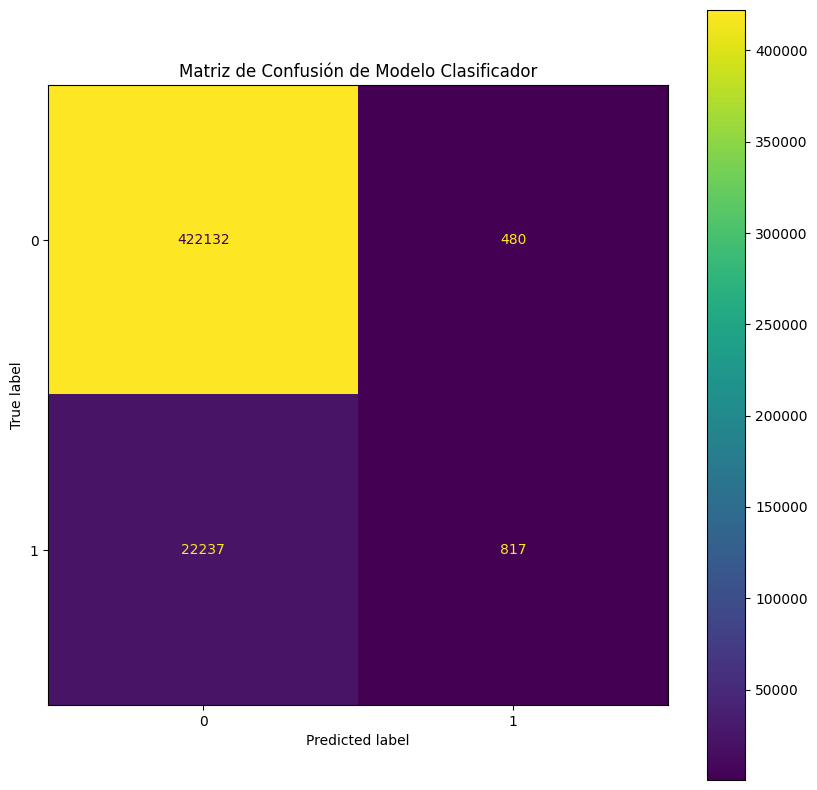

Accuracy: 0.9490268497035896
Precision: 0.9490268497035896
Recall: 0.9490268497035896
F1 Score: 0.9490268497035896

Performance Metrics on Train Set:


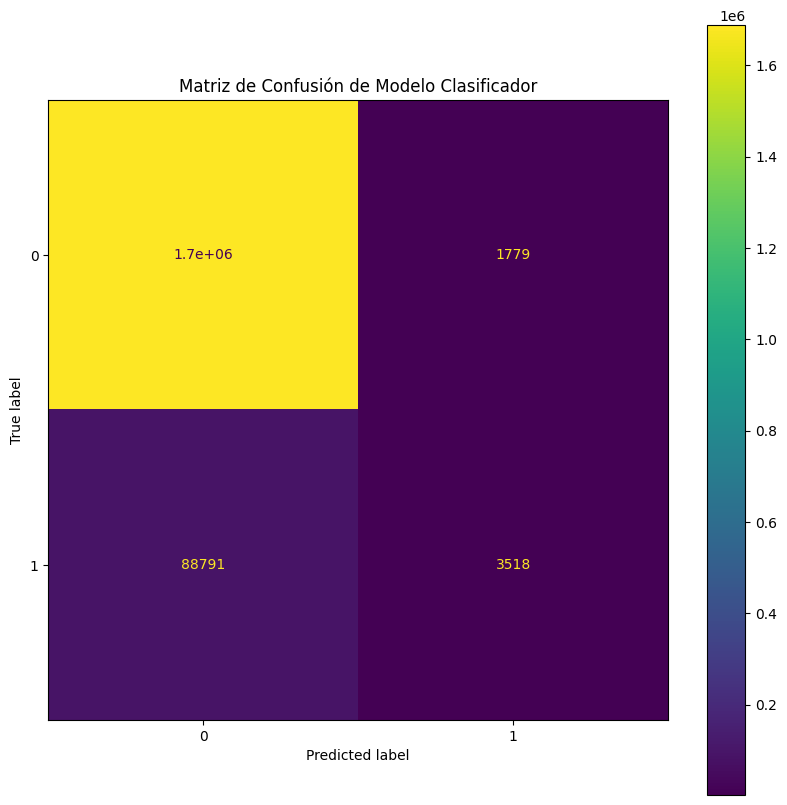

Accuracy: 0.9491939582489558
Precision: 0.9491939582489558
Recall: 0.9491939582489558
F1 Score: 0.9491939582489558


In [15]:
clf = CreateAndTestClassifier(X_train, X_test, y_train, y_test)

### Ajuste de Hiperparámetros

Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 300}

Performance Metrics on Test Set:


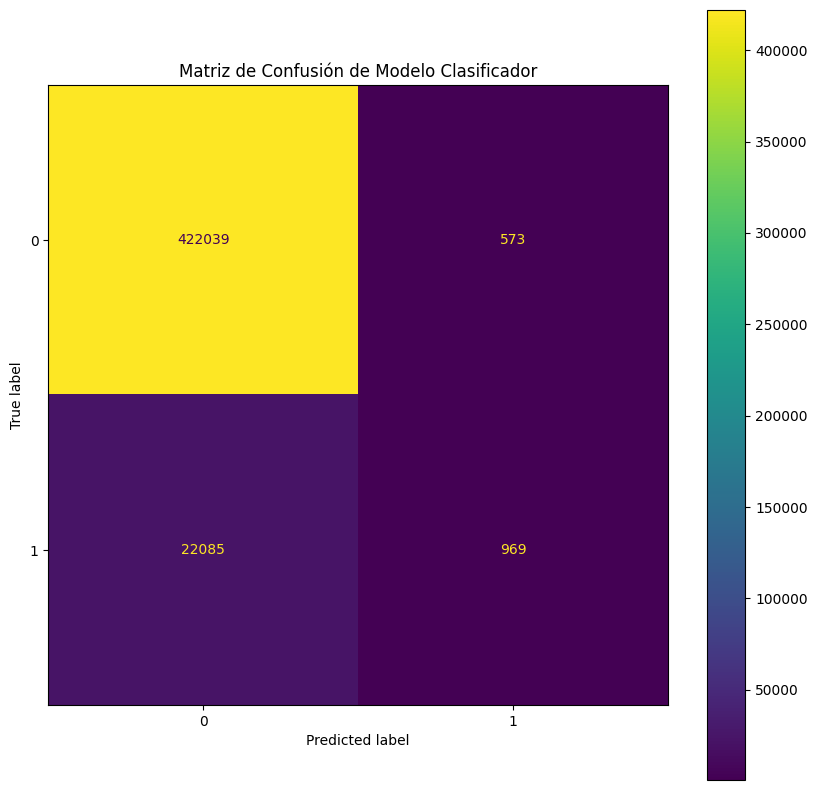

Accuracy: 0.9491592358402929
Precision: 0.9491592358402929
Recall: 0.9491592358402929
F1 Score: 0.9491592358402929

Performance Metrics on Train Set:


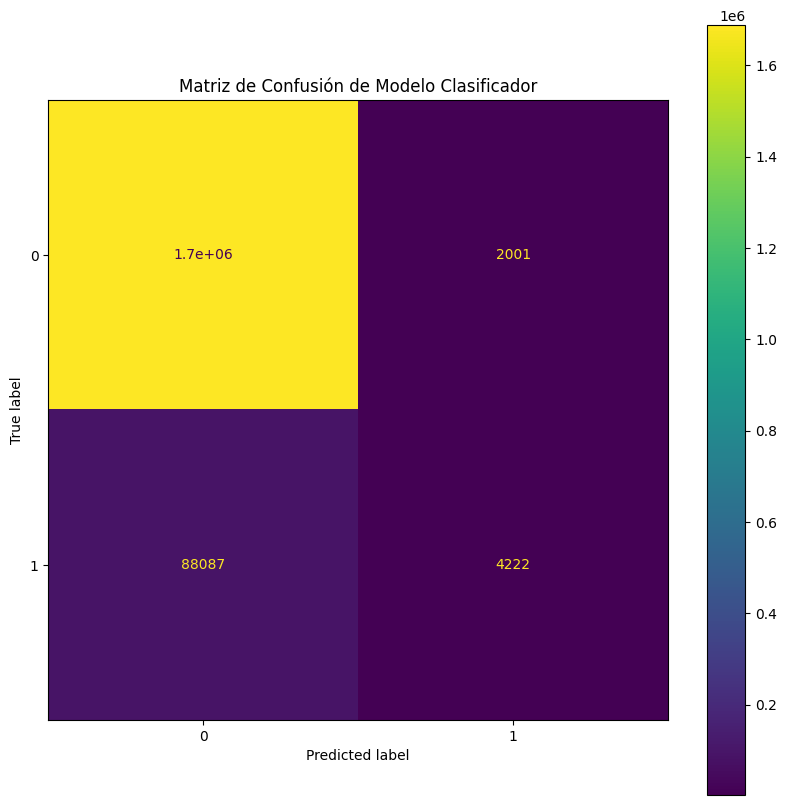

Accuracy: 0.9494643404077722
Precision: 0.9494643404077722
Recall: 0.9494643404077722
F1 Score: 0.9494643404077722


In [18]:
clf = TuneAndTestClassifier(X_train, X_test, y_train, y_test)

## Segunda Iteración de Modelo de Clasificación

Esta segunda iteración cuenta con el conjunto de datos original, con algunos pasos de preprocesamiento adicionales para la posible reducción del desbalanceo y ruido que se presenta en la base de datos original.

### Preparación y Separación del Conjunto de Datos

In [22]:
df_cp = df.copy()

df_cp.pop('municipio')
df_cp.pop('region')
df_cp = df_cp[df_cp['departamento'] == 'Guatemala']
df_cp.pop('departamento')

freqs = df_cp['dias_estancia'].value_counts()
df_cp = df_cp.loc[df['dias_estancia'] <= 30]

# Filter out the rows where the frequency is not equal to 1
uniques = freqs[freqs == 1].index
df_cp = df_cp[~df_cp['dias_estancia'].isin(uniques)]

removed = df_cp.pop('dias_estancia')


In [23]:
# Separate the target variable 'categoria_estancia' into y and the rest of the DataFrame into X
y = df_cp.pop('categoria_estancia')
X = df_cp

print(X.shape)
print(y.shape)

(1190137, 7)
(1190137,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

print(X_train.shape)
print(y_train.shape)

(952109, 7)
(952109,)


### Entrenamiento del Modelo y Métricas Iniciales

Performance Metrics on Test Set:


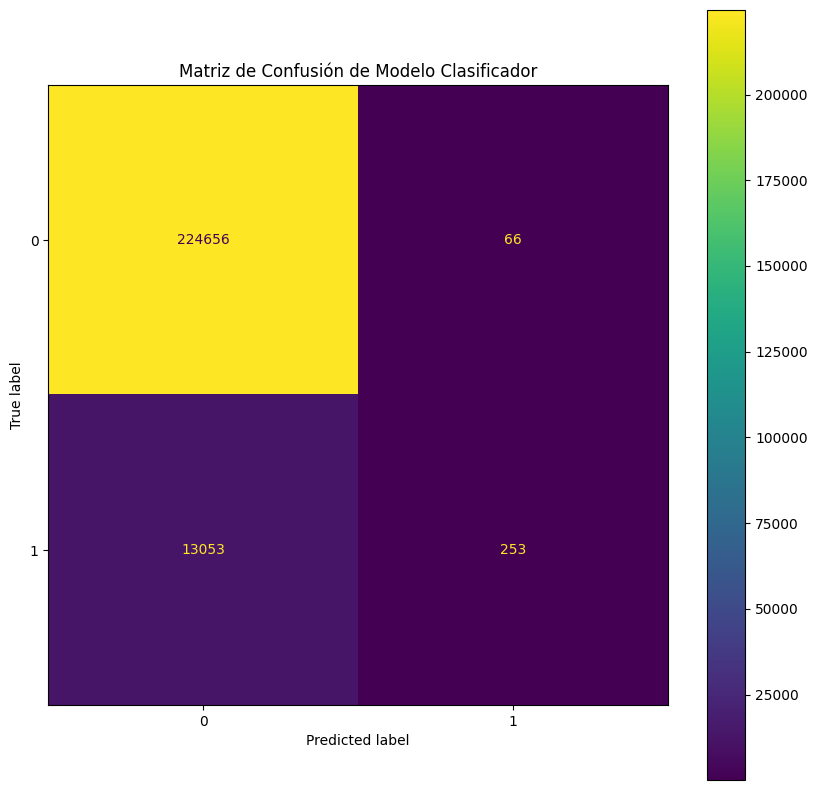

Accuracy: 0.944884635421043
Precision: 0.944884635421043
Recall: 0.944884635421043
F1 Score: 0.944884635421043

Performance Metrics on Train Set:


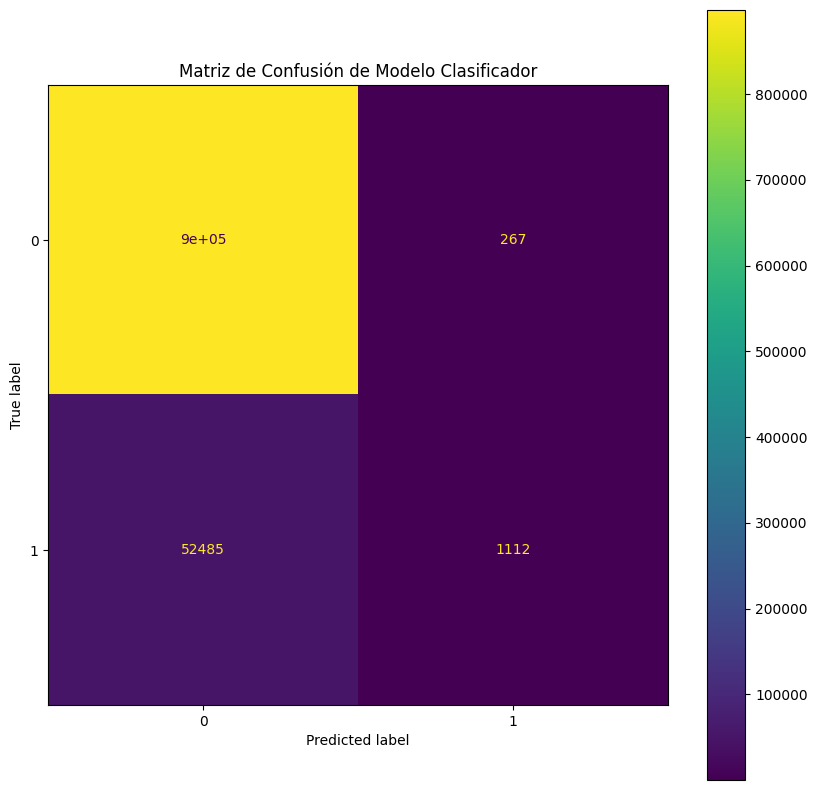

Accuracy: 0.9445945789820284
Precision: 0.9445945789820284
Recall: 0.9445945789820284
F1 Score: 0.9445945789820284


In [25]:
clf = CreateAndTestClassifier(X_train, X_test, y_train, y_test)

### Tuneo de Hiperparámetros

Best Parameters: {'learning_rate': 0.2, 'max_depth': 15, 'max_iter': 200}

Performance Metrics on Test Set:


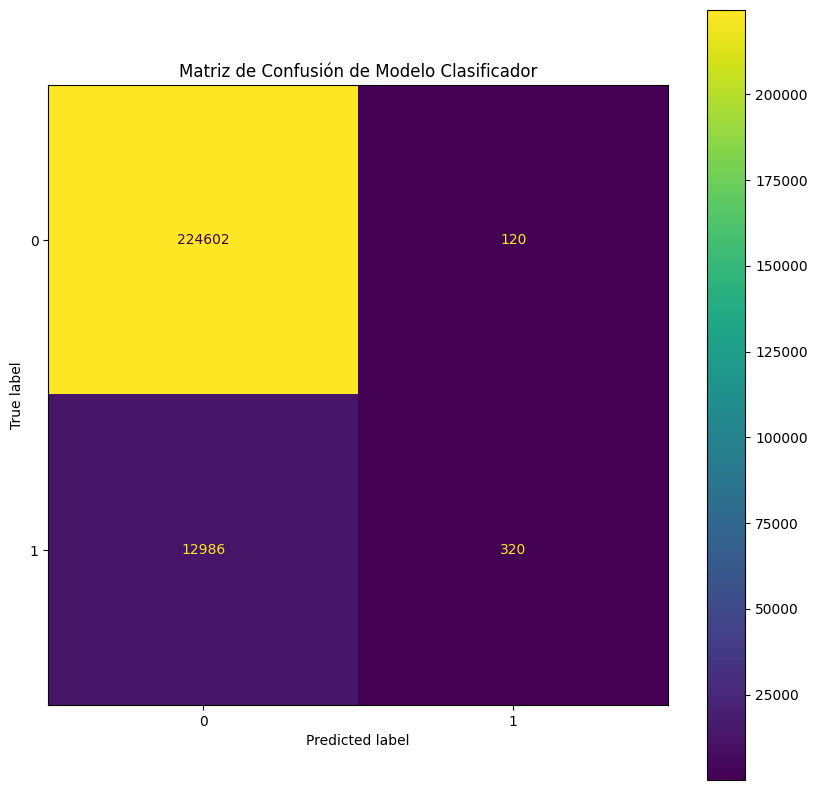

Accuracy: 0.9449392508444384
Precision: 0.9449392508444384
Recall: 0.9449392508444384
F1 Score: 0.9449392508444384

Performance Metrics on Train Set:


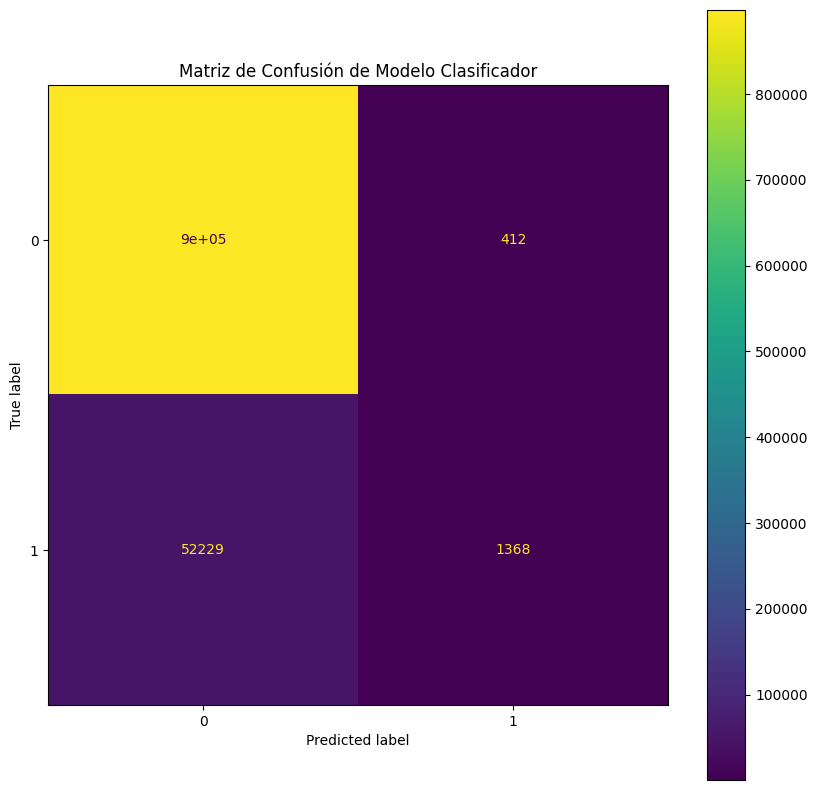

Accuracy: 0.9447111622723868
Precision: 0.9447111622723868
Recall: 0.9447111622723868
F1 Score: 0.9447111622723868


In [26]:
clf = TuneAndTestClassifier(X_train, X_test, y_train, y_test)

## Tercera Iteración del Modelo de Clasificación

Esta tercera iteración cuenta con el filtrado del conjunto de datos realizado para el modelo anterior, además de la inclusión del algoritmo SMOTEENN para el balanceo de la variable respuesta.

### Preparación y Separación del Conjunto de Datos

In [31]:
df_cp = df.copy()

df_cp.pop('municipio')
df_cp.pop('region')
df_cp = df_cp[df_cp['departamento'] == 'Guatemala']
df_cp.pop('departamento')

freqs = df_cp['dias_estancia'].value_counts()
df_cp = df_cp.loc[df['dias_estancia'] <= 30]

# Filter out the rows where the frequency is not equal to 1
uniques = freqs[freqs == 1].index
df_cp = df_cp[~df_cp['dias_estancia'].isin(uniques)]

removed = df_cp.pop('dias_estancia')

El algoritmo de resampling SMOTEENN no es capaz de lidiar con datos categóricos de manera nativa, por lo que se deben codificar todas las variables categóricas antes de utilizarlo.

In [32]:
# Initialize the encoder
encoder = OrdinalEncoder()

categoricalVariables = ['sexo', 'grupo_etnico', 'tratamiento_recibido', 'causa_categoria', 'edad_categoria']

# Reshape the input data to a 2-dimensional array
data = df[categoricalVariables]  # Selecting the columns you want to encode
data = data.values  # No need to reshape as we have multiple columns

# Fit and transform the encoder on the reshaped data
encoded_data = encoder.fit_transform(data)

# Assign the encoded data back to the DataFrame
df[categoricalVariables] = encoded_data

In [33]:
# Separate the target variable 'categoria_estancia' into y and the rest of the DataFrame into X
y = df_cp.pop('categoria_estancia')
X = df_cp

# SMOTEENN Resampling
rus = SMOTEENN(random_state=random_state)
X_resampled, y_resampled = rus.fit_resample(X, y)

print(X_resampled.shape)
print(y_resampled.shape)

(1641974, 7)
(1641974,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=test_size, random_state=random_state)

print(X_train.shape)
print(y_train.shape)

(1313579, 7)
(1313579,)


### Entrenamiento del Modelo y Métricas Iniciales

Performance Metrics on Test Set:


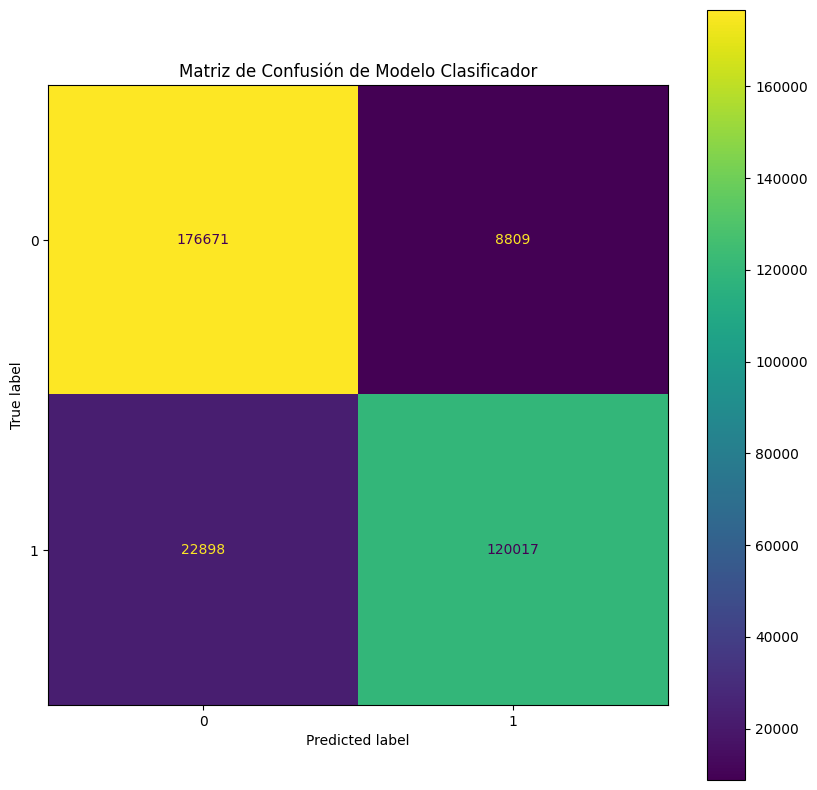

Accuracy: 0.9034485908737953
Precision: 0.9034485908737953
Recall: 0.9034485908737953
F1 Score: 0.9034485908737953

Performance Metrics on Train Set:


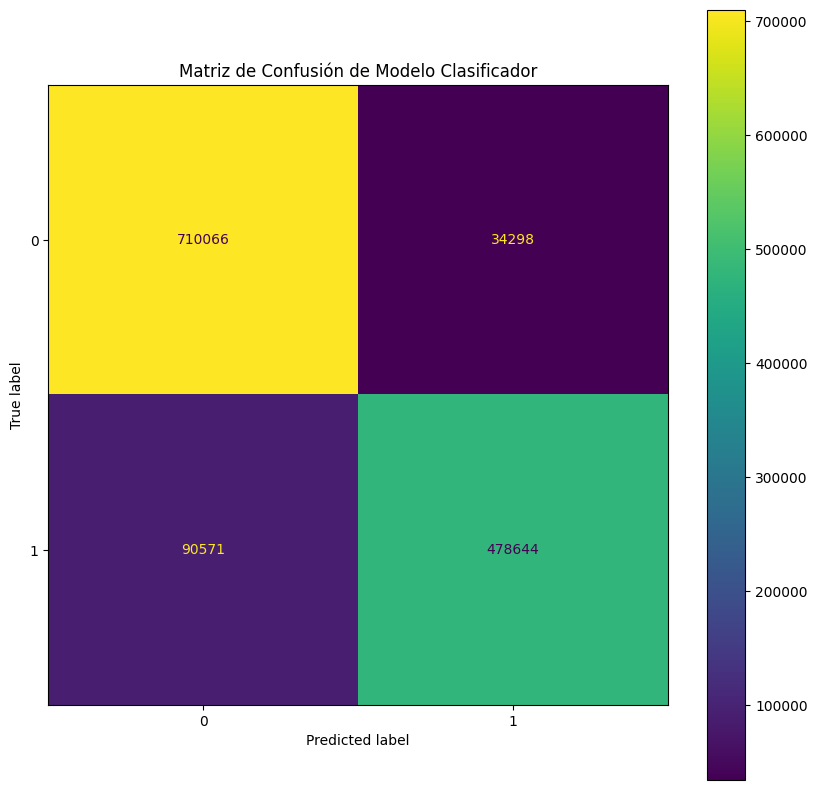

Accuracy: 0.9049398627718622
Precision: 0.9049398627718622
Recall: 0.9049398627718622
F1 Score: 0.9049398627718622


In [35]:
clf = CreateAndTestClassifier(X_train, X_test, y_train, y_test)

### Tuneo de Hiperparámetros

Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'max_iter': 300}

Performance Metrics on Test Set:


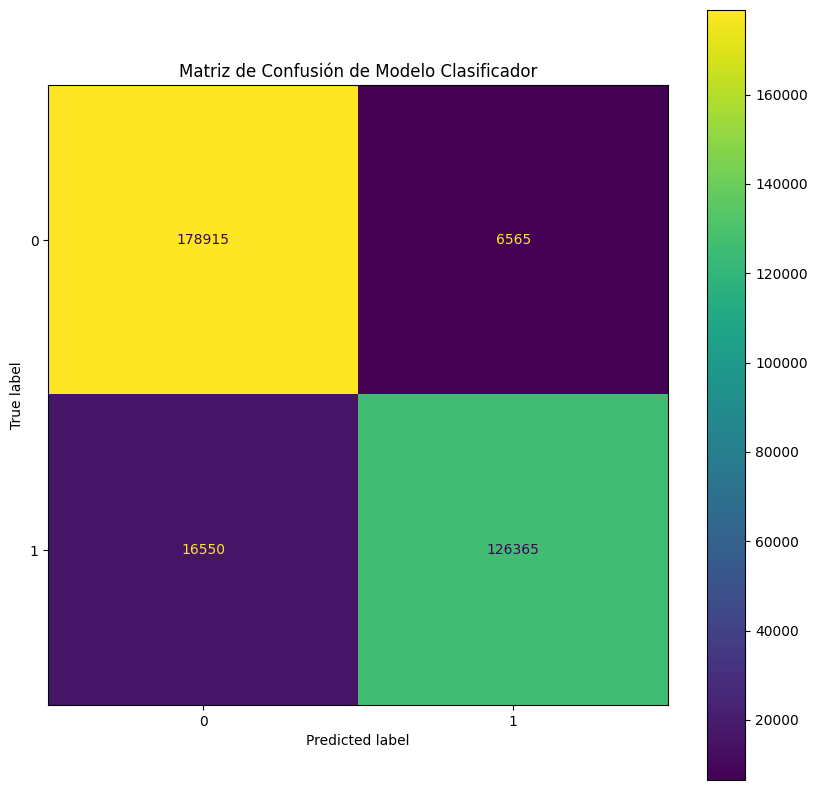

Accuracy: 0.9296122048143242
Precision: 0.9296122048143242
Recall: 0.9296122048143242
F1 Score: 0.9296122048143242

Performance Metrics on Train Set:


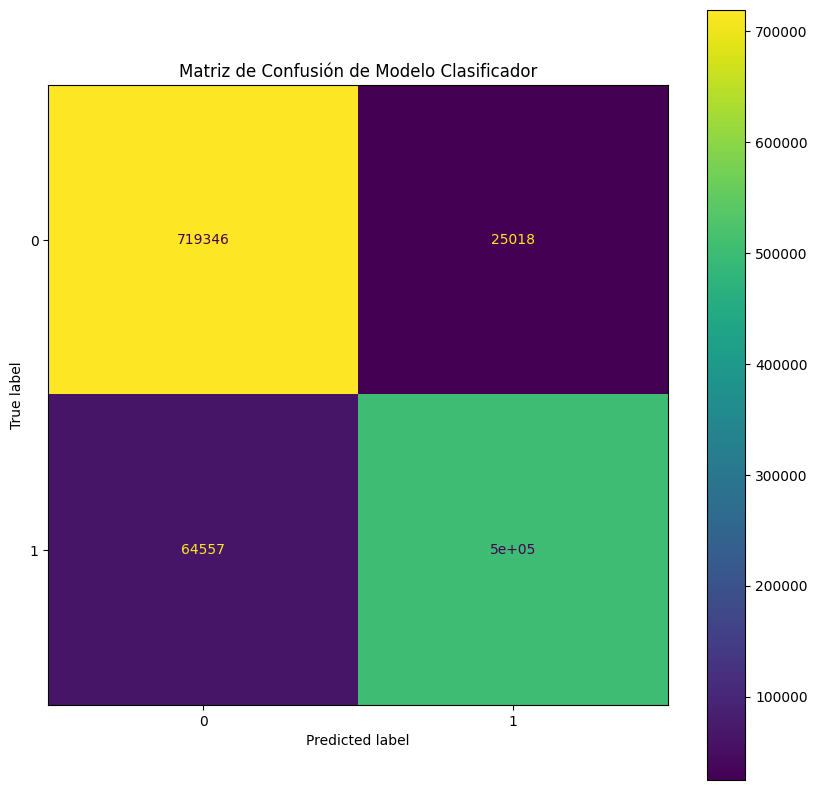

Accuracy: 0.9318084409083884
Precision: 0.9318084409083884
Recall: 0.9318084409083884
F1 Score: 0.9318084409083884


In [36]:
clf = TuneAndTestClassifier(X_train, X_test, y_train, y_test)